In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('C:/Users/Hrishikesh/Desktop/rohan/gold_monthly.csv')
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
df.shape

(847, 2)

In [79]:
df.isnull().sum()

Price    0
dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847 entries, 1950-01-31 to 2020-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   847 non-null    float64
dtypes: float64(1)
memory usage: 13.2 KB


In [5]:
print(f"Date Range of Gold Prices avaliable from = {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date Range of Gold Prices avaliable from = 1950-01 to 2020-07


In [6]:
date = pd.date_range (start = '1/1/1950', end = '8/1/2020', freq = 'M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [7]:
df['Month'] = date
df.drop('Date', axis = 1, inplace = True)
df = df.set_index('Month')
df.head()

,Price
Month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


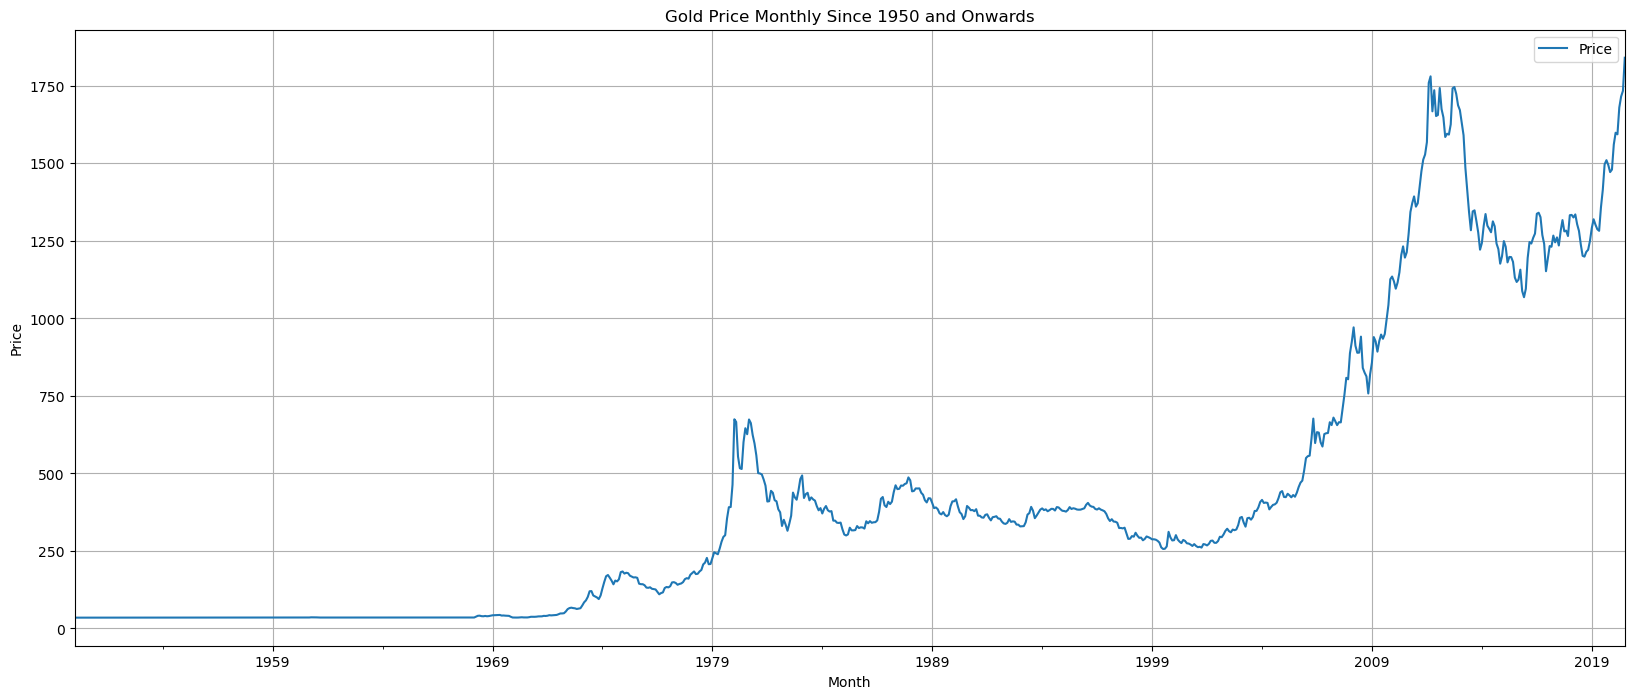

In [8]:
df.plot(figsize = (20,8))
plt.title("Gold Price Monthly Since 1950 and Onwards")
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid()

In [9]:
round(df.describe(),2)

,Price
count,847.00
mean,416.56
std,453.67
min,34.49
25%,35.19
50%,319.62
75%,447.03
max,1840.81


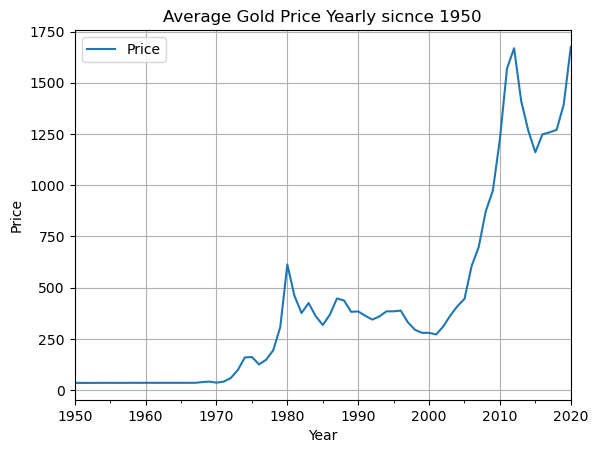

In [10]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Gold Price Yearly sicnce 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

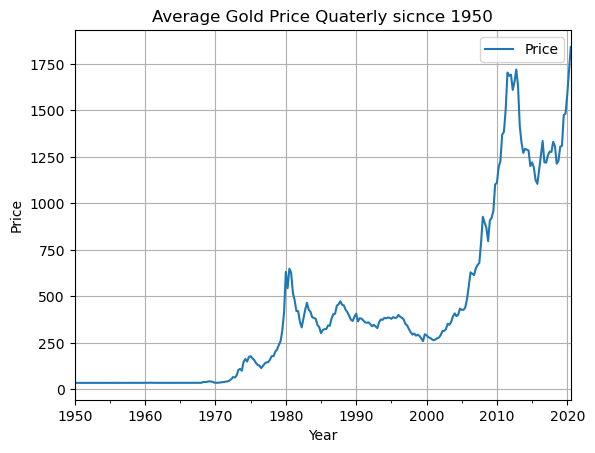

In [11]:
df_quarterly_sum = df.resample("Q").mean()
df_quarterly_sum.plot()
plt.title("Average Gold Price Quaterly sicnce 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

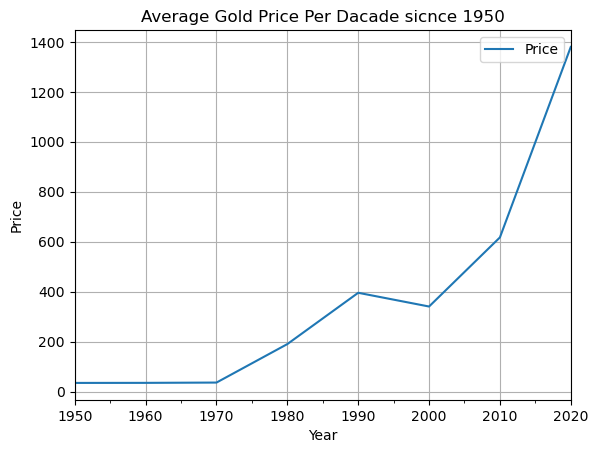

In [12]:
df_decade_sum = df.resample("10Y").mean()
df_decade_sum.plot()
plt.title("Average Gold Price Per Dacade sicnce 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

In [13]:
df_1 = df.groupby(df.index.year).mean().rename(columns = {'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns = {"Price":"Std"}),left_index = True, right_index = True)
df_1["Cov_pct"] = ((df_1["Std"]/df_1["Mean"])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
Month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


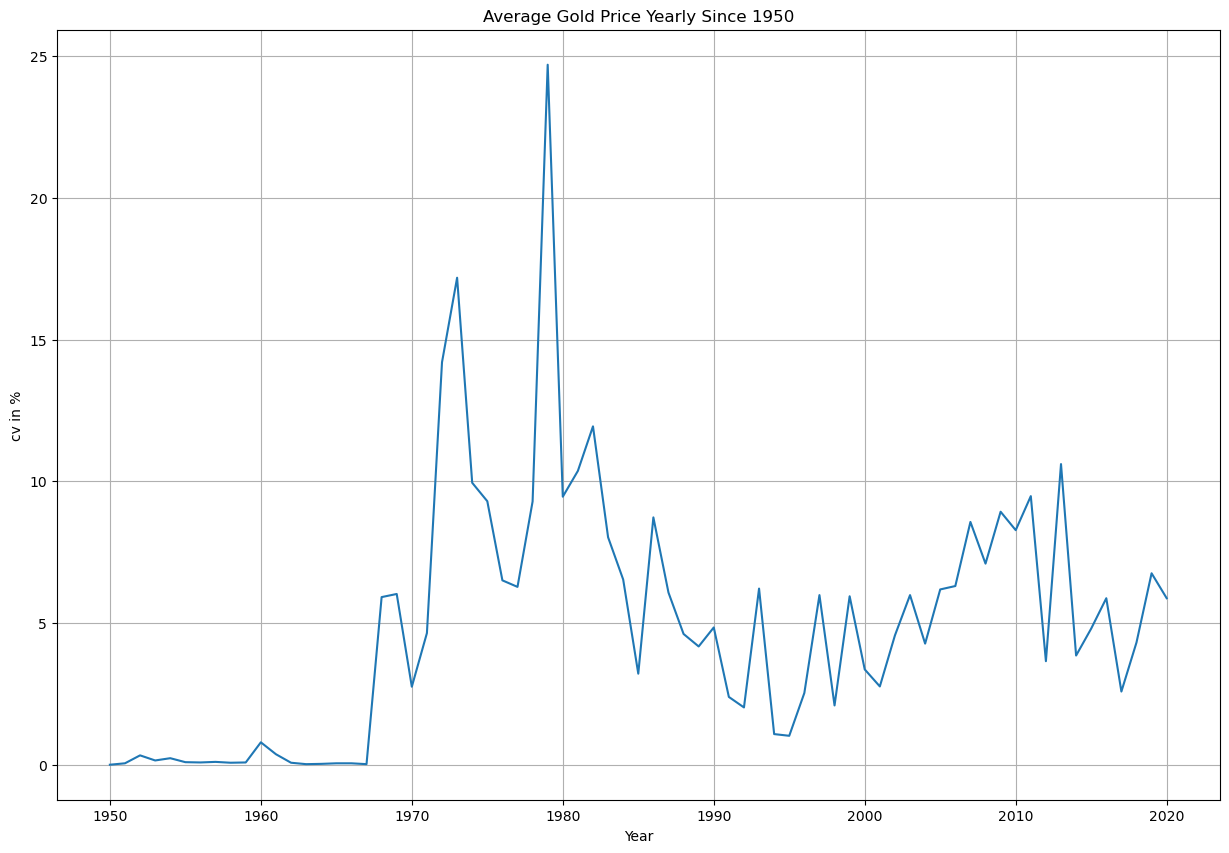

In [14]:
fig, ax = plt.subplots(figsize = (15, 10))
df_1["Cov_pct"].plot()
plt.title("Average Gold Price Yearly Since 1950")
plt.xlabel("Year")
plt.ylabel("cv in %")
plt.grid()

In [15]:
train = df[df.index.year <= 2015]
test  = df[df.index.year >  2015]

In [17]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


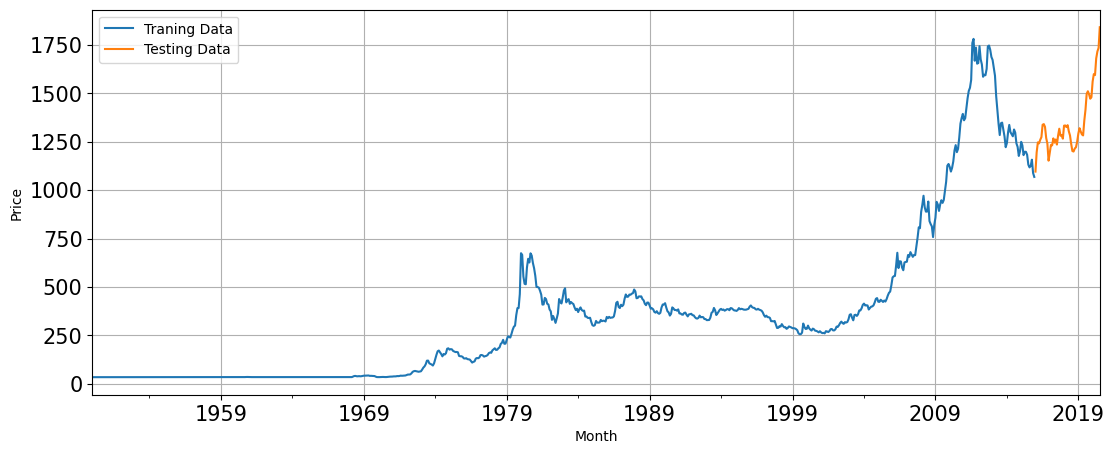

In [22]:
train["Price"].plot(figsize=(13,5), fontsize=15)
test["Price"].plot(figsize=(13,5), fontsize=15)
plt.legend(["Traning Data","Testing Data"])
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid()
plt.show()

In [23]:
train_time = [i+1 for i in range(len(train))]
test_time  = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [24]:
LR_train = train.copy()
LR_test  = test.copy()

In [25]:
LR_train["time"] = train_time
LR_test["time"]  = test_time

In [27]:
lr = LinearRegression()
lr.fit(LR_train[["time"]],LR_train["Price"].values)

LinearRegression()

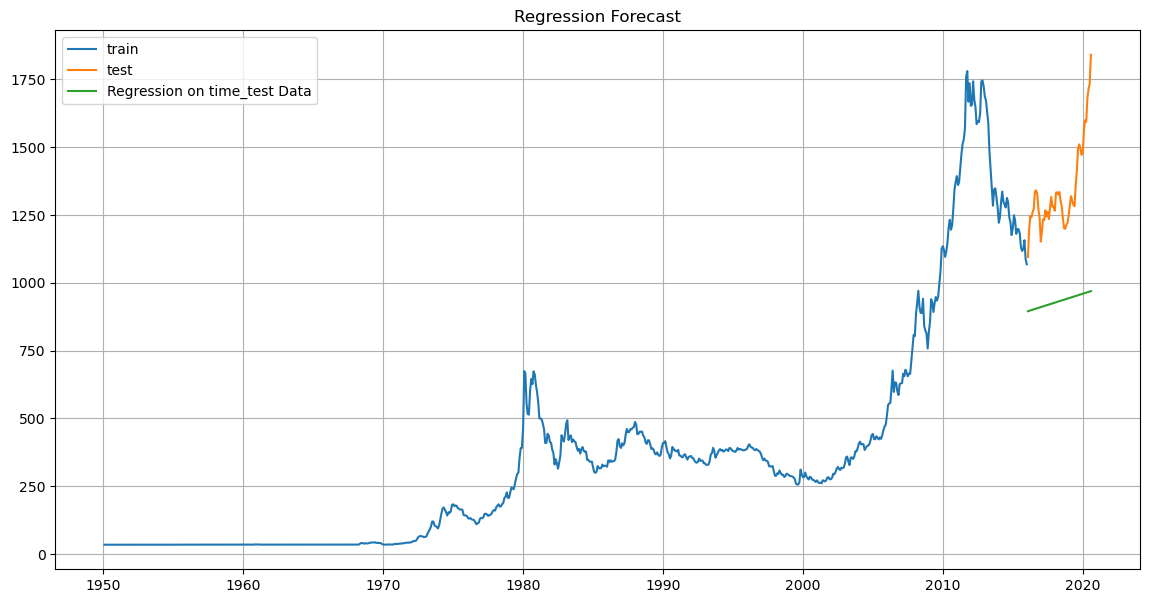

In [84]:
test_predictions_model1 = lr.predict(LR_test[["time"]])
LR_test["forecast"] = test_predictions_model1

plt.figure(figsize = (14, 7))
plt.plot(train["Price"], label = "train")
plt.plot(test["Price"], label = "test")
plt.plot(LR_test["forecast"],label = "Regression on time_test Data")
plt.legend(loc = "best")
plt.title("Regression Forecast")
plt.grid()

In [36]:
def mape(actual,pred):
    return round((np.mean(abs(actual - pred)/actual))*100,2)

In [38]:
mape_model1_test = mape(test["Price"].values,test_predictions_model1)
print("MAPE is %3.3f"%(mape_model1_test),"%")

MAPE is 29.760 %


In [40]:
results = pd.DataFrame({"Test Mape (%)": [mape_model1_test]}, index = ["RegressionTime"])
results

,Test Mape (%)
RegressionTime,29.76


In [42]:
Naive_train = train.copy()
Naive_test  = test.copy()

In [44]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train["Price"]))-1]
Naive_test["naive"].head()

Month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

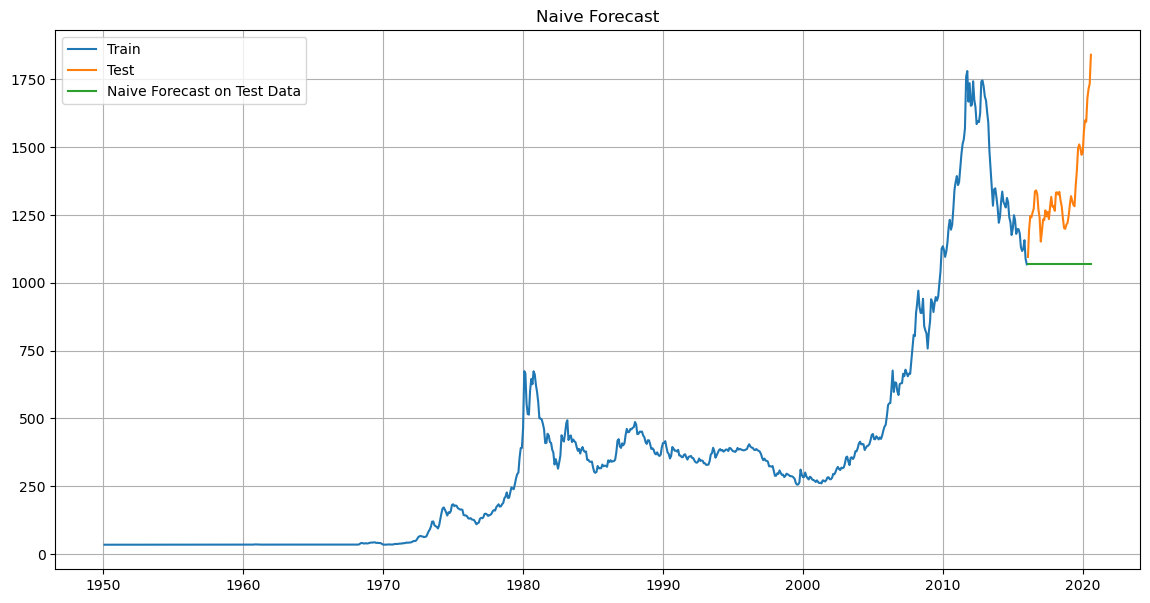

In [48]:
plt.figure(figsize=(14,7))
plt.plot(Naive_train["Price"], label="Train")
plt.plot(test["Price"], label="Test")
plt.plot(Naive_test["naive"], label ="Naive Forecast on Test Data")
plt.legend(loc="best")
plt.title("Naive Forecast")
plt.grid()

In [49]:
mape_model2_test = mape(test["Price"].values,Naive_test["naive"].values)
print("For Naive Forecast on the Test Data, MAPE is %3.3f" %(mape_model2_test),"%")

For Naive Forecast on the Test Data, MAPE is 19.380 %


In [50]:
resultsDF_2 = pd.DataFrame({"Test MAPE (%)": [mape_model2_test]},index=["NaiveModel"])
results = pd.concat([results, resultsDF_2])
results

,Test Mape (%),Test MAPE (%)
RegressionTime,29.76,NaN
NaiveModel,NaN,19.38


In [58]:
final_model = ExponentialSmoothing(df,
                                   trend = "additive",
                                   seasonal = "additive").fit(smoothing_level = 0.4,
                                                                                smoothing_trend = 0.3,
                                                                                smoothing_seasonal = 0.6)

In [59]:
Mape_final_model = mape(df["Price"].values, final_model.fittedvalues)
print("MAPE:",Mape_final_model)

MAPE: 17.24


In [85]:
prediction = final_model.forecast(steps=len(test))

In [75]:
pred_df = pd.DataFrame({"Lower_CI":prediction - 1.96*np.std(final_model.resid),
                       "Prediction":prediction,
                       "Upper_CI": prediction + 1.96*np.std(final_model.resid)})
pred_df.head()

,Lower_CI,Prediction,Upper_CI
2020-08-31,1684.782137,1792.869246,1900.956356
2020-09-30,1615.365678,1723.452788,1831.539897
2020-10-31,1538.624741,1646.711851,1754.798961
2020-11-30,1476.812694,1584.899804,1692.986914
2020-12-31,1459.379072,1567.466182,1675.553292


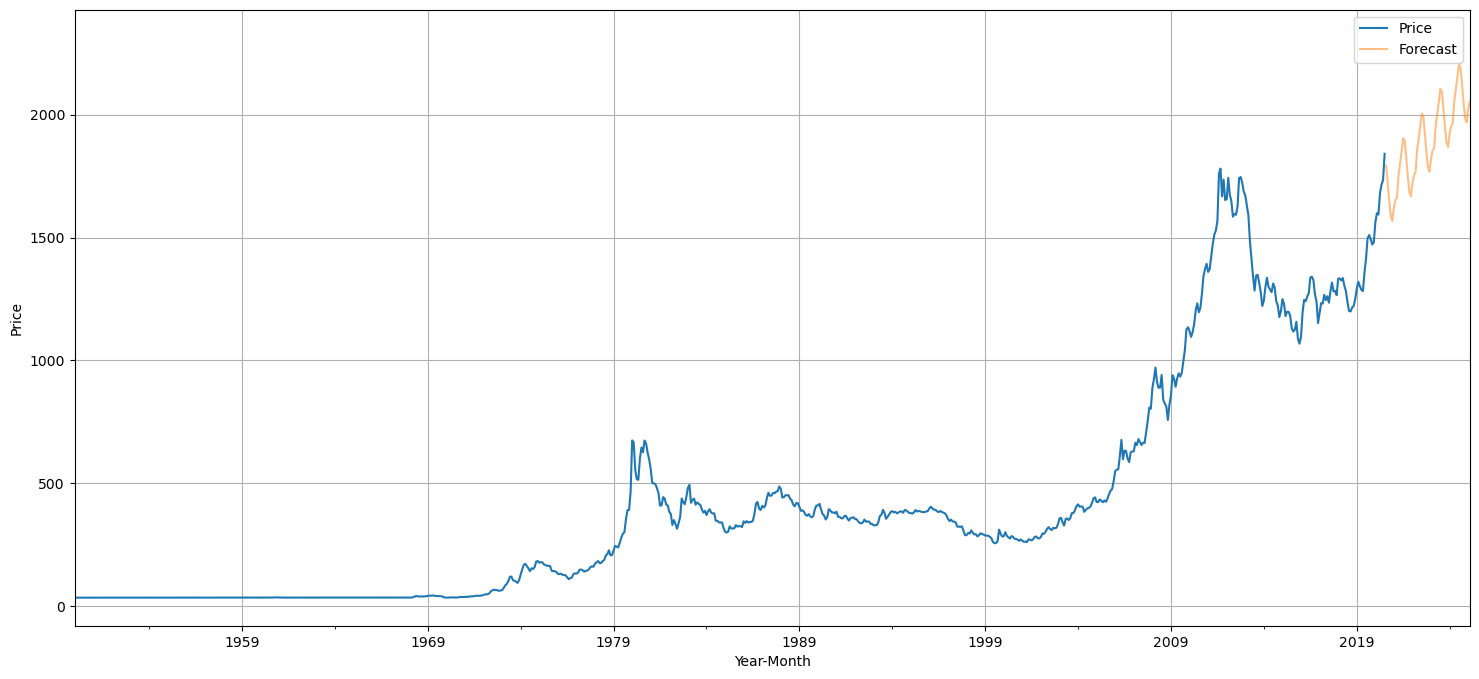

In [78]:
axis = df.plot(label = 'actual', figsize=(18,8))
pred_df["Prediction"].plot(ax = axis, label = "Forecast", alpha = 0.5)
axis.fill_between(pred_df.index,pred_df["Lower_CI"], pred_df["Upper_CI"], color = "m",alpha = .15)
axis.set_xlabel("Year-Month")
axis.set_ylabel("Price")
plt.legend(loc = "best")
plt.grid()
plt.show()